In [0]:
!ls

'$AAL.xlsx'   adc.json	 bert   sample_data   test-dataset


In [0]:
from google.colab import files
files.download('$AAL.xlsx')

In [0]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime

In addition to the standard libraries we imported above, we'll need to install BERT's python package.

In [0]:
!pip install bert-tensorflow

     |████████████████████████████████| 71kB 27.1MB/s 


In [0]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

W0629 07:07:48.086206 139690991851392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/bert/optimization.py:87: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
OUTPUT_DIR = 'bert'

In [0]:
from tensorflow import keras
import os
import re

def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
  
  return train_df, test_df

In [0]:
train, test = download_and_load_datasets()

84131840/84125825 [==============================] - 10s 0us/step


In [0]:
train = train.sample(5000)
test = test.sample(5000)

In [0]:
train.columns

Index(['sentence', 'sentiment', 'polarity'], dtype='object')

In [0]:
DATA_COLUMN = 'sentence'
LABEL_COLUMN = 'polarity'
# label_list is the list of labels, i.e. True, False or 0, 1 or 'dog', 'cat'
label_list = [0, 1]

In [0]:
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [0]:
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

W0629 07:17:17.587021 139690991851392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/bert/tokenization.py:125: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



In [0]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

W0629 07:18:15.556199 139690991851392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/bert/run_classifier.py:774: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.



In [0]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs =           (
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)
  output_layer = bert_outputs["pooled_output"]
  hidden_size = output_layer.shape[-1].value
  
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)
    
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    if is_predicting:
      return (predicted_labels, log_probs)

    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)


In [0]:
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  def model_fn(features, labels, mode, params):
    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)
  return model_fn


In [0]:
# hyperparameters 
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [0]:
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [0]:
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [0]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


In [0]:
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

In [0]:
print(f'Training Start')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training End ", datetime.now() - current_time)

Beginning Training!


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Training took time  0:08:25.068716


In [0]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [0]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
W0629 08:19:39.511466 139690991851392 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


{'auc': 0.8664946,
 'eval_accuracy': 0.8668,
 'f1_score': 0.87182444,
 'false_negatives': 260.0,
 'false_positives': 406.0,
 'global_step': 468,
 'loss': 0.5635893,
 'precision': 0.847997,
 'recall': 0.8970297,
 'true_negatives': 2069.0,
 'true_positives': 2265.0}

In [0]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference


In [0]:
template = ('\nPrediction is "{}" ({:.1f}%)')

def getPrediction(in_sentences):
  labels = ["Negative", "Positive"]
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] # here, "" is just a dummy label
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  
  res = []
  for sentence, prediction in zip(in_sentences, predictions):
    number = prediction['labels']
    pos = softmax(prediction['probabilities'])[number]
    #print(template.format(labels[number],100 * softmax(prediction['probabilities'])[number]))
    
    res.append((sentence, softmax(prediction['probabilities']), labels[number]))
    
  
  return res

In [0]:
!pip install xlsxwriter

     |████████████████████████████████| 143kB 44.4MB/s 


In [0]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import StandardScaler
import pandas_datareader.data as web
import math
import xlsxwriter
import os

In [0]:
!git clone https://github.com/zzbslayer/test-dataset.git

Cloning into 'test-dataset'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


In [0]:
xls = pd.ExcelFile('./test-dataset/AAL.xlsx') # CHANGE FILE NAME!!!

stock = "AAL" #CHANGE STOCK TICKER!!!

In [0]:
df = pd.read_excel(xls, header = 0,encoding='latin-1', sheet_name = "Stream")

df.head()

,Tweet Id,Date,Hour,User Name,Nickname,Bio,Tweet content,Favs,RTs,Latitude,Longitude,Country,Place (as appears on Bio),Profile picture,Followers,Following,Listed,Tweet language (ISO 639-1),Tweet Url,Is a RT,Original Tweet User Name,User Mentions,Hashtags,Symbols,Media,URLs
0,743011665663295491,2016-06-15,09:26,Scutify,scutify,Scuttlebutt + Finance = Scutify. The most inno...,"Why American Airlines Group Inc $AAL, Novo Nor...",NaN,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/4512219832...,2039.0,108.0,109.0,en,http://www.twitter.com/scutify/status/74301166...,False,NaN,NaN,NaN,"$AAL,$NVO,$SYF",NaN,https://www.scutify.com/articles/2016-06-15-wh...
1,742994700563558400,2016-06-15,08:18,Halifax ShareDealing,halifaxbroker,Authorised and regulated by the Financial Cond...,Yesterday's top #FTSE100 fallers - Anglo Ameri...,NaN,NaN,53.79648,-1.54785,GB,"Leeds, UK",http://pbs.twimg.com/profile_images/4564568165...,1792.0,80.0,43.0,en,http://www.twitter.com/halifaxbroker/status/74...,False,NaN,NaN,#FTSE100,"$AAL,$ANTO,$SKY,$BKG,$BLT",NaN,NaN
2,742991573181423618,2016-06-15,08:06,TradeWithSuper,TradeWithSuper,The Twitter handle 4 @TopFiveTraders that foll...,SA_QuickIdeas: 5 Large-Cap Stocks With The Low...,NaN,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/7308147701...,1589.0,1376.0,110.0,en,http://www.twitter.com/TradeWithSuper/status/7...,False,NaN,NaN,NaN,"$AAL,$DAL,$HPQ,$TTM,$UAL,$VLO",NaN,http://seekingalpha.com/article/3982103-5-larg...
3,742991250899513345,2016-06-15,08:04,WKRB News,WKRBNews,WKRB News - News and Analysis. http://t.co/n4Q...,JPMorgan Chase &amp; Co. Reiterates Underweigh...,NaN,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/3788000007...,771.0,8.0,124.0,de,http://www.twitter.com/WKRBNews/status/7429912...,False,NaN,NaN,NaN,$AAL,NaN,http://ift.tt/1UTFj1G
4,742990282380173313,2016-06-15,08:01,ProVesting,ProVesting,NaN,$DAL $AAL:\n\n5 Large-Cap Stocks With The Lowe...,NaN,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/5423921744...,788.0,6.0,140.0,en,http://www.twitter.com/ProVesting/status/74299...,False,NaN,NaN,NaN,"$DAL,$AAL",NaN,http://www.StockNewsWires.com/2016/06/15/dal-a...


In [0]:
Tweet = df['Tweet content']
Tweet.head()

0    Why American Airlines Group Inc $AAL, Novo Nor...
1    Yesterday's top #FTSE100 fallers - Anglo Ameri...
2    SA_QuickIdeas: 5 Large-Cap Stocks With The Low...
3    JPMorgan Chase &amp; Co. Reiterates Underweigh...
4    $DAL $AAL:\n\n5 Large-Cap Stocks With The Lowe...
Name: Tweet content, dtype: object

In [0]:
def cal_compound(neg, pos):
    return pos - neg
  
def sentimentScore(Tweet):
    results = []
    scores = getPrediction(Tweet)
    for sentence, score in zip(Tweet, scores):
        vs = {}
        vs["neg"] = score[1][0]
        vs["pos"] = score[1][1]
        vs["compound"] = cal_compound(vs["neg"], vs["pos"])
        print("Score: " + str(vs))
        #print("{: <65} {}".format(sentence, str(vs))) 
        #NOTE! I blocked the second print command so the sentences are
        #left out in the cell below, purely for clarity reasons
        results.append(vs)
    return results

In [0]:
df_results = pd.DataFrame(sentimentScore(Tweet))

Score: {'neg': 0.997589, 'pos': 0.0024110293, 'compound': -0.995178}
Score: {'neg': 0.24370478, 'pos': 0.7562952, 'compound': 0.5125904}
Score: {'neg': 0.90639055, 'pos': 0.093609504, 'compound': -0.81278104}
Score: {'neg': 0.67134523, 'pos': 0.32865474, 'compound': -0.3426905}
Score: {'neg': 0.86078286, 'pos': 0.13921714, 'compound': -0.7215657}
Score: {'neg': 0.68387043, 'pos': 0.3161295, 'compound': -0.36774093}
Score: {'neg': 0.7093117, 'pos': 0.29068825, 'compound': -0.41862348}
Score: {'neg': 0.6959005, 'pos': 0.30409947, 'compound': -0.39180103}
Score: {'neg': 0.5497992, 'pos': 0.4502008, 'compound': -0.09959841}
Score: {'neg': 0.9690564, 'pos': 0.030943535, 'compound': -0.9381129}
Score: {'neg': 0.98100084, 'pos': 0.018999109, 'compound': -0.96200174}
Score: {'neg': 0.45716998, 'pos': 0.54283005, 'compound': 0.08566007}
Score: {'neg': 0.35639548, 'pos': 0.6436045, 'compound': 0.28720903}
Score: {'neg': 0.99749196, 'pos': 0.0025081092, 'compound': -0.99498385}
Score: {'neg': 0.8

In [0]:
df_tweets = pd.merge(df, df_results, left_index=True, right_index=True)

df_tweets.tail()

,Tweet Id,Date,Hour,User Name,Nickname,Bio,Tweet content,Favs,RTs,Latitude,Longitude,Country,Place (as appears on Bio),Profile picture,Followers,Following,Listed,Tweet language (ISO 639-1),Tweet Url,Is a RT,Original Tweet User Name,User Mentions,Hashtags,Symbols,Media,URLs,compound,neg,pos
6502,707914551908552705,2016-03-10,13:02,Brian D. Colwell,BColwell_EMGMKT,#EmergingMarkets #EmergingMarket #Africa #Asia...,#Cuba: U.S. #airlines vie 4 #latinamerica flig...,1.0,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/6452834729...,248.0,156.0,85.0,en,http://www.twitter.com/BColwell_EMGMKT/status/...,False,NaN,NaN,"#Cuba,#airlines,#latinamerica,#emergingmarket","$AAL,$DAL,$JBLU,$LUV,$UAL,$ALK,$VWO,$EEM,$FM,$ILF",NaN,http://ow.ly/Z1Nj0,-0.008277,0.504139,0.495861
6503,707908040348016640,2016-03-10,12:36,Paul Henry,MoneyMarketzz,NaN,Our New Stock Pick Is On $PSNP &amp; It's Pick...,NaN,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/6093787062...,12543.0,NaN,77.0,en,http://www.twitter.com/MoneyMarketzz/status/70...,False,NaN,NaN,NaN,"$PSNP,$DROP,$AAL,$SVMI",NaN,http://tr.im/vUWIb,0.990894,0.004553,0.995447
6504,707907421889495040,2016-03-10,12:34,Michael James,TheStockGuyz,NaN,Our Hot New Stock Alert Is $PSNP! Things Are R...,NaN,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/6093761545...,19713.0,NaN,69.0,en,http://www.twitter.com/TheStockGuyz/status/707...,False,NaN,NaN,NaN,"$PSNP,$DROP,$AAL,$SVMI",NaN,http://bit.ly/1RSCiQy,0.869858,0.065071,0.934929
6505,707906875690512385,2016-03-10,12:32,Michael Cook,Stockfiendz,NaN,This Mineral Exploration Company Is Heating Up...,NaN,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/6083677946...,12556.0,NaN,69.0,en,http://www.twitter.com/Stockfiendz/status/7079...,False,NaN,NaN,NaN,"$DROP,$AAL,$SVMI",NaN,http://goo.gl/ryjCm7,0.743123,0.128438,0.871562
6506,707859062738669569,2016-03-10,09:22,thepeople4stocks,thepeople4stoc1,NaN,AAL Exchange\nSee Here ---&gt; https://t.co/OT...,NaN,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/6973396725...,19.0,40.0,12.0,en,http://www.twitter.com/thepeople4stoc1/status/...,False,NaN,NaN,#tradeideas,"$AAL,$MITK,$ANTH",NaN,http://dlvr.it/Kl4HZh,0.305387,0.347307,0.652693


In [0]:
df_tweets = df_tweets[(df_tweets['Date'] >= '2016-04-01') & (df_tweets['Date'] <= '2016-06-14')]

df_tweets.tail()

,Tweet Id,Date,Hour,User Name,Nickname,Bio,Tweet content,Favs,RTs,Latitude,Longitude,Country,Place (as appears on Bio),Profile picture,Followers,Following,Listed,Tweet language (ISO 639-1),Tweet Url,Is a RT,Original Tweet User Name,User Mentions,Hashtags,Symbols,Media,URLs,compound,neg,pos
5733,715721241710227457,2016-04-01,02:03,BreakingStocksNews,NewsToDesk,News about Stocks,$AAL:\n\nAmerican Airlines Group’s (AAL) “Outp...,NaN,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/5622923817...,699.0,1.0,129.0,en,http://www.twitter.com/NewsToDesk/status/71572...,False,NaN,NaN,NaN,$AAL,NaN,http://StockNewsHour.com/aal-american-airlines...,-0.616645,0.808323,0.191677
5734,715717917606862850,2016-04-01,01:50,US Consumer News,ConsumerFeed,News for Consumers in a Changing World,American Airlines Group's outperform rating re...,NaN,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/379977873/...,4519.0,2839.0,532.0,en,http://www.twitter.com/ConsumerFeed/status/715...,False,NaN,NaN,#AAL,$AAL,NaN,http://ift.tt/1MFrvdE,-0.649646,0.824823,0.175177
5735,715717224686813184,2016-04-01,01:47,China Invest,ChinaInvest,An investor in Hong Kong focusing in China sto...,RT SeekingAlpha: Airplane And Hospitality Indu...,1.0,1.0,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/6518125466...,8560.0,3.0,857.0,en,http://www.twitter.com/ChinaInvest/status/7157...,False,NaN,NaN,NaN,"$HOT,$MAR,$JBLU,$DAL,$LUV,$AAL,$ALK",NaN,http://seekingalpha.com/article/3962425-airpla...,0.146218,0.426891,0.573109
5736,715716602730323968,2016-04-01,01:45,MarketBeatCom,RatingsNetwork,Formerly Analyst Ratings Network. http://t.co/...,American Airlines Group's outperform rating re...,NaN,1.0,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/6054339229...,4001.0,1.0,512.0,en,http://www.twitter.com/RatingsNetwork/status/7...,False,NaN,NaN,#AAL,$AAL,NaN,http://ift.tt/1MFrvdE,-0.613940,0.806970,0.193030
5737,715692661068468224,2016-04-01,00:10,Yamasuta,YamasutaTrader,Yamasuta is an algorithmic stock analysis soft...,"$AAL - BUY Signal at 41.38 on Mar 30, 16 By ht...",NaN,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/5394593423...,276.0,5.0,50.0,en,http://www.twitter.com/YamasutaTrader/status/7...,False,NaN,NaN,"#Stockmarket,#trading,#trade,#investing",$AAL,NaN,http://YaMasuta.com,-0.016482,0.508241,0.491759


In [0]:
df_tweets['datetime'] = pd.to_datetime(df_tweets['Date'])
df_tweet_Datetime = df_tweets.set_index('datetime')
df_tweet_Datetime.drop(['Date'], axis=1, inplace=True)
df_tweet_Datetime.head()

,Tweet Id,Hour,User Name,Nickname,Bio,Tweet content,Favs,RTs,Latitude,Longitude,Country,Place (as appears on Bio),Profile picture,Followers,Following,Listed,Tweet language (ISO 639-1),Tweet Url,Is a RT,Original Tweet User Name,User Mentions,Hashtags,Symbols,Media,URLs,compound,neg,pos
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-14,742866928872476672,23:50,Airlines News,_airlines_,Track all of the latest Airlines News with Owl...,#AmericanAirlines Cabin Chaos Triggers Turbule...,NaN,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/6931651141...,31.0,3.0,6.0,en,http://www.twitter.com/_airlines_/status/74286...,False,NaN,NaN,#AmericanAirlines,$AAL,NaN,http://owler.us/aaQRCN,-0.647714,0.823857,0.176143
2016-06-14,742864743002574848,23:42,1 min Stock Insights,1MinuteStock,"Flash, 1 minute stock insights about trending ...",Explore #fundamental numbers and pros and cons...,NaN,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/6781804912...,1398.0,1495.0,73.0,en,http://www.twitter.com/1MinuteStock/status/742...,False,NaN,NaN,#fundamental,$AAL,NaN,https://unicornbay.com/t/AAL.US?utm_medium=twe...,0.748029,0.125985,0.874015
2016-06-14,742862512878682112,23:33,dailystockplays.com,DailyStockPlays,"Live Day Trading Calls, Daily Swing Trading Li...",Expansion BD https://t.co/5WSaOfRETR $IMGN $CO...,NaN,NaN,37.25022,-119.75126,US,California,http://pbs.twimg.com/profile_images/7178505158...,4864.0,2512.0,120.0,en,http://www.twitter.com/DailyStockPlays/status/...,False,NaN,NaN,NaN,"$IMGN,$COF,$LYG,$STNG,$LUV,$ALLY,$SMFG,$ING,$M...",NaN,http://www.dailystockplays.com/Expansion-BD-20...,-0.359602,0.679801,0.320199
2016-06-14,742856061606985728,23:07,Sarcasm Bot,sarcbot,Don't take this bot seriously. It was an exper...,$AAL big time shorts and options traders seem ...,NaN,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/4989198314...,163.0,6.0,14.0,en,http://www.twitter.com/sarcbot/status/74285606...,False,NaN,NaN,NaN,$AAL,NaN,NaN,0.848394,0.075803,0.924197
2016-06-14,742852413929836544,22:53,1 min Stock Insights,1MinuteStock,"Flash, 1 minute stock insights about trending ...",Wondering about risks of $AAL? The 21-day vola...,NaN,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/profile_images/6781804912...,1398.0,1495.0,73.0,en,http://www.twitter.com/1MinuteStock/status/742...,False,NaN,NaN,NaN,$AAL,NaN,https://unicornbay.com/t/AAL.US?utm_medium=twe...,-0.385622,0.692811,0.307189


In [0]:
df_tweet_Datetime = df_tweets[['Date','Hour','Tweet content','Favs','RTs','Followers','Following', 'Is a RT', 
                'Hashtags','Symbols','compound','neg','pos','datetime']]
df_tweet_Datetime.head()

,Date,Hour,Tweet content,Favs,RTs,Followers,Following,Is a RT,Hashtags,Symbols,compound,neg,pos,datetime
17,2016-06-14,23:50,#AmericanAirlines Cabin Chaos Triggers Turbule...,NaN,NaN,31.0,3.0,False,#AmericanAirlines,$AAL,-0.647714,0.823857,0.176143,2016-06-14
18,2016-06-14,23:42,Explore #fundamental numbers and pros and cons...,NaN,NaN,1398.0,1495.0,False,#fundamental,$AAL,0.748029,0.125985,0.874015,2016-06-14
19,2016-06-14,23:33,Expansion BD https://t.co/5WSaOfRETR $IMGN $CO...,NaN,NaN,4864.0,2512.0,False,NaN,"$IMGN,$COF,$LYG,$STNG,$LUV,$ALLY,$SMFG,$ING,$M...",-0.359602,0.679801,0.320199,2016-06-14
20,2016-06-14,23:07,$AAL big time shorts and options traders seem ...,NaN,NaN,163.0,6.0,False,NaN,$AAL,0.848394,0.075803,0.924197,2016-06-14
21,2016-06-14,22:53,Wondering about risks of $AAL? The 21-day vola...,NaN,NaN,1398.0,1495.0,False,NaN,$AAL,-0.385622,0.692811,0.307189,2016-06-14


In [0]:
df_tweet_Datetime['Compound_multiplied'] = df_tweet_Datetime['compound']*df_tweet_Datetime['Followers']
df_tweet_Datetime.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Date,Hour,Tweet content,Favs,RTs,Followers,Following,Is a RT,Hashtags,Symbols,compound,neg,pos,datetime,Compound_multiplied
5733,2016-04-01,02:03,$AAL:\n\nAmerican Airlines Group’s (AAL) “Outp...,NaN,NaN,699.0,1.0,False,NaN,$AAL,-0.616645,0.808323,0.191677,2016-04-01,-431.035090
5734,2016-04-01,01:50,American Airlines Group's outperform rating re...,NaN,NaN,4519.0,2839.0,False,#AAL,$AAL,-0.649646,0.824823,0.175177,2016-04-01,-2935.750202
5735,2016-04-01,01:47,RT SeekingAlpha: Airplane And Hospitality Indu...,1.0,1.0,8560.0,3.0,False,NaN,"$HOT,$MAR,$JBLU,$DAL,$LUV,$AAL,$ALK",0.146218,0.426891,0.573109,2016-04-01,1251.627882
5736,2016-04-01,01:45,American Airlines Group's outperform rating re...,NaN,1.0,4001.0,1.0,False,#AAL,$AAL,-0.613940,0.806970,0.193030,2016-04-01,-2456.374419
5737,2016-04-01,00:10,"$AAL - BUY Signal at 41.38 on Mar 30, 16 By ht...",NaN,NaN,276.0,5.0,False,"#Stockmarket,#trading,#trade,#investing",$AAL,-0.016482,0.508241,0.491759,2016-04-01,-4.548932


In [0]:
nan_rows = df_tweet_Datetime[df_tweet_Datetime['Followers'].isnull()]
len(nan_rows)

60

In [0]:
df_tweet_Datetime = df_tweet_Datetime[np.isfinite(df_tweet_Datetime['Followers'])]

In [0]:
x_1 = df_tweet_Datetime[['Compound_multiplied']].values.astype(float)

scaler = StandardScaler().fit(x_1)

scaled_data = scaler.transform(x_1)

df_tweet_Datetime['Compound_multiplied_scaled'] = scaled_data

df_tweet_Datetime.tail()

,Date,Hour,Tweet content,Favs,RTs,Followers,Following,Is a RT,Hashtags,Symbols,compound,neg,pos,datetime,Compound_multiplied,Compound_multiplied_scaled
5733,2016-04-01,02:03,$AAL:\n\nAmerican Airlines Group’s (AAL) “Outp...,NaN,NaN,699.0,1.0,False,NaN,$AAL,-0.616645,0.808323,0.191677,2016-04-01,-431.035090,-0.026352
5734,2016-04-01,01:50,American Airlines Group's outperform rating re...,NaN,NaN,4519.0,2839.0,False,#AAL,$AAL,-0.649646,0.824823,0.175177,2016-04-01,-2935.750202,-0.091019
5735,2016-04-01,01:47,RT SeekingAlpha: Airplane And Hospitality Indu...,1.0,1.0,8560.0,3.0,False,NaN,"$HOT,$MAR,$JBLU,$DAL,$LUV,$AAL,$ALK",0.146218,0.426891,0.573109,2016-04-01,1251.627882,0.017092
5736,2016-04-01,01:45,American Airlines Group's outperform rating re...,NaN,1.0,4001.0,1.0,False,#AAL,$AAL,-0.613940,0.806970,0.193030,2016-04-01,-2456.374419,-0.078642
5737,2016-04-01,00:10,"$AAL - BUY Signal at 41.38 on Mar 30, 16 By ht...",NaN,NaN,276.0,5.0,False,"#Stockmarket,#trading,#trade,#investing",$AAL,-0.016482,0.508241,0.491759,2016-04-01,-4.548932,-0.015340


In [0]:
df_daily_mean=(df_tweet_Datetime.groupby(df_tweet_Datetime.datetime).mean())

df_daily_mean.tail()

,Favs,RTs,Followers,Following,Is a RT,compound,neg,pos,Compound_multiplied,Compound_multiplied_scaled
datetime,,,,,,,,,,
2016-06-10,2.125000,2.500000,1829.946108,1313.407407,0.083832,0.153642,0.423179,0.576821,417.520394,-0.004443
2016-06-11,5.666667,6.666667,5051.161290,795.466667,0.419355,-0.057188,0.528594,0.471406,-365.311262,-0.024655
2016-06-12,1.000000,5.000000,1793.545455,1427.761905,0.045455,0.188475,0.405763,0.594237,1104.855246,0.013302
2016-06-13,1.800000,10.600000,6803.033613,552.857143,0.168067,0.050464,0.474768,0.525232,-4421.367370,-0.129375
2016-06-14,2.076923,3.965517,8343.198582,1634.832117,0.127660,-0.091170,0.545585,0.454415,4356.227466,0.097247


In [0]:
df_daily_mean

,Favs,RTs,Followers,Following,Is a RT,compound,neg,pos,Compound_multiplied,Compound_multiplied_scaled
datetime,,,,,,,,,,
2016-04-01,1.000000,1.906250,3156.930435,694.245098,0.156522,-0.141677,0.570838,0.429162,-725.682705,-0.033959
2016-04-02,1.562500,1.885714,16486.241935,10707.666667,0.193548,-0.076278,0.538139,0.461861,-1081.196762,-0.043138
2016-04-03,1.900000,1.000000,13450.297297,6385.138889,0.054054,0.139410,0.430295,0.569705,4050.588638,0.089356
2016-04-04,1.428571,1.235294,6381.905983,3934.963636,0.034188,-0.080719,0.540359,0.459641,-783.904119,-0.035462
2016-04-05,1.000000,1.000000,1706.460526,425.723077,0.013158,0.139145,0.430427,0.569573,616.823682,0.000702
2016-04-06,1.000000,1.000000,1040.590909,333.288136,0.015152,0.232377,0.383811,0.616189,512.770015,-0.001984
2016-04-07,1.000000,1.000000,1702.322581,969.603448,0.016129,0.078149,0.460925,0.539075,313.710144,-0.007124
2016-04-08,NaN,NaN,918.477273,792.047619,0.000000,0.213120,0.393440,0.606560,-114.889432,-0.018189
2016-04-09,1.000000,1.000000,5169.250000,1936.090909,0.083333,-0.115133,0.557567,0.442433,-1601.074590,-0.056560


In [0]:
start = dt.datetime(2016, 4, 1)
end =  dt.datetime(2016, 6, 14)
df_stock = web.DataReader(stock, 'yahoo', start, end)
df_stock.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-04-01,40.160000,39.270000,40.130001,39.520000,11244100.0,38.267448
2016-04-04,40.240002,39.150002,39.810001,39.369999,7831200.0,38.122200
2016-04-05,39.380001,38.740002,39.130001,38.930000,7648400.0,37.696152
2016-04-06,39.070000,38.340000,39.070000,38.900002,5650000.0,37.667107
2016-04-07,39.049999,37.910000,38.660000,38.360001,8206700.0,37.144211


In [0]:
df_stock.columns = ['High','Low','Open','Close','Volume_stock','Adj_Close_stock']
df_stock['HiLo_vola_stock'] = (df_stock['High'] - df_stock['Low']) / df_stock['Adj_Close_stock'] * 100.0
df_stock['Pct_change_stock'] = (df_stock['Close'] - df_stock['Open']) / df_stock['Open'] * 100.0

In [0]:
stock_1 = df_stock[['Pct_change_stock']].values.astype(float)
scaler = StandardScaler().fit(stock_1)
scaled_data = scaler.transform(stock_1)
df_stock['Pct_change_stock_scaled'] = scaled_data
df_stock

,High,Low,Open,Close,Volume_stock,Adj_Close_stock,HiLo_vola_stock,Pct_change_stock,Pct_change_stock_scaled
Date,,,,,,,,,
2016-04-01,40.160000,39.270000,40.130001,39.520000,11244100.0,38.267448,2.325735,-1.520061,-0.588352
2016-04-04,40.240002,39.150002,39.810001,39.369999,7831200.0,38.122200,2.859227,-1.105256,-0.352325
2016-04-05,39.380001,38.740002,39.130001,38.930000,7648400.0,37.696152,1.697784,-0.511119,-0.014256
2016-04-06,39.070000,38.340000,39.070000,38.900002,5650000.0,37.667107,1.938029,-0.435112,0.028992
2016-04-07,39.049999,37.910000,38.660000,38.360001,8206700.0,37.144211,3.069117,-0.775994,-0.164972
2016-04-08,38.720001,38.119999,38.700001,38.500000,6087400.0,37.279778,1.609458,-0.516798,-0.017488
2016-04-11,39.549999,38.669998,38.790001,38.730000,7932300.0,37.502487,2.346514,-0.154683,0.188559
2016-04-12,39.430000,38.759998,38.820000,39.189999,6426000.0,37.947910,1.765583,0.953114,0.818903
2016-04-13,40.009998,38.889999,39.299999,39.939999,12493500.0,38.674141,2.895989,1.628497,1.203201


In [0]:
df_full = pd.concat([df_stock[['Volume_stock','Adj_Close_stock','HiLo_vola_stock','Pct_change_stock', 'Pct_change_stock_scaled']],\
                     df_daily_mean], axis=1, sort=False)
df_full

,Volume_stock,Adj_Close_stock,HiLo_vola_stock,Pct_change_stock,Pct_change_stock_scaled,Favs,RTs,Followers,Following,Is a RT,compound,neg,pos,Compound_multiplied,Compound_multiplied_scaled
2016-04-01,11244100.0,38.267448,2.325735,-1.520061,-0.588352,1.000000,1.906250,3156.930435,694.245098,0.156522,-0.141677,0.570838,0.429162,-725.682705,-0.033959
2016-04-02,NaN,NaN,NaN,NaN,NaN,1.562500,1.885714,16486.241935,10707.666667,0.193548,-0.076278,0.538139,0.461861,-1081.196762,-0.043138
2016-04-03,NaN,NaN,NaN,NaN,NaN,1.900000,1.000000,13450.297297,6385.138889,0.054054,0.139410,0.430295,0.569705,4050.588638,0.089356
2016-04-04,7831200.0,38.122200,2.859227,-1.105256,-0.352325,1.428571,1.235294,6381.905983,3934.963636,0.034188,-0.080719,0.540359,0.459641,-783.904119,-0.035462
2016-04-05,7648400.0,37.696152,1.697784,-0.511119,-0.014256,1.000000,1.000000,1706.460526,425.723077,0.013158,0.139145,0.430427,0.569573,616.823682,0.000702
2016-04-06,5650000.0,37.667107,1.938029,-0.435112,0.028992,1.000000,1.000000,1040.590909,333.288136,0.015152,0.232377,0.383811,0.616189,512.770015,-0.001984
2016-04-07,8206700.0,37.144211,3.069117,-0.775994,-0.164972,1.000000,1.000000,1702.322581,969.603448,0.016129,0.078149,0.460925,0.539075,313.710144,-0.007124
2016-04-08,6087400.0,37.279778,1.609458,-0.516798,-0.017488,NaN,NaN,918.477273,792.047619,0.000000,0.213120,0.393440,0.606560,-114.889432,-0.018189
2016-04-09,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,5169.250000,1936.090909,0.083333,-0.115133,0.557567,0.442433,-1601.074590,-0.056560
2016-04-10,NaN,NaN,NaN,NaN,NaN,2.333333,2.800000,3339.083333,1012.735294,0.194444,0.110559,0.444720,0.555280,687.800365,0.002535


In [0]:
df_full['Favs'].fillna(df_full['Favs'].mean(), inplace=True)
df_full['RTs'].fillna(df_full['RTs'].mean(), inplace=True)
df_full['Followers'].fillna(df_full['Followers'].mean(), inplace=True)
df_full['Following'].fillna(df_full['Following'].mean(), inplace=True)
df_full['Is a RT'].fillna(df_full['Is a RT'].mean(), inplace=True)
df_full['compound'].fillna(df_full['compound'].mean(), inplace=True)
df_full['neg'].fillna(df_full['neg'].mean(), inplace=True)
df_full['pos'].fillna(df_full['pos'].mean(), inplace=True)
df_full['Compound_multiplied'].fillna(df_full['Compound_multiplied'].mean(), inplace=True)
df_full['Compound_multiplied_scaled'].fillna(df_full['Compound_multiplied_scaled'].mean(), inplace=True)

df_full.tail()

,Volume_stock,Adj_Close_stock,HiLo_vola_stock,Pct_change_stock,Pct_change_stock_scaled,Favs,RTs,Followers,Following,Is a RT,compound,neg,pos,Compound_multiplied,Compound_multiplied_scaled
2016-06-10,8252300.0,32.182426,2.610121,1.036586,0.866399,2.125000,2.500000,1829.946108,1313.407407,0.083832,0.153642,0.423179,0.576821,417.520394,-0.004443
2016-06-11,NaN,NaN,NaN,NaN,NaN,5.666667,6.666667,5051.161290,795.466667,0.419355,-0.057188,0.528594,0.471406,-365.311262,-0.024655
2016-06-12,NaN,NaN,NaN,NaN,NaN,1.000000,5.000000,1793.545455,1427.761905,0.045455,0.188475,0.405763,0.594237,1104.855246,0.013302
2016-06-13,9225600.0,30.881145,4.371607,-3.607161,-1.775928,1.800000,10.600000,6803.033613,552.857143,0.168067,0.050464,0.474768,0.525232,-4421.367370,-0.129375
2016-06-14,13802900.0,29.482754,6.614032,-4.558311,-2.317140,2.076923,3.965517,8343.198582,1634.832117,0.127660,-0.091170,0.545585,0.454415,4356.227466,0.097247


In [0]:
df_full[[ "Volume_stock", "Adj_Close_stock", "HiLo_vola_stock", "Pct_change_stock", "Pct_change_stock_scaled"]] = \
df_full[[ "Volume_stock", "Adj_Close_stock", "HiLo_vola_stock", "Pct_change_stock", "Pct_change_stock_scaled"]] \
.interpolate(method='linear', limit_direction='forward', axis=0)
df_full.tail()

,Volume_stock,Adj_Close_stock,HiLo_vola_stock,Pct_change_stock,Pct_change_stock_scaled,Favs,RTs,Followers,Following,Is a RT,compound,neg,pos,Compound_multiplied,Compound_multiplied_scaled
2016-06-10,8.252300e+06,32.182426,2.610121,1.036586,0.866399,2.125000,2.500000,1829.946108,1313.407407,0.083832,0.153642,0.423179,0.576821,417.520394,-0.004443
2016-06-11,8.576733e+06,31.748666,3.197283,-0.511330,-0.014376,5.666667,6.666667,5051.161290,795.466667,0.419355,-0.057188,0.528594,0.471406,-365.311262,-0.024655
2016-06-12,8.901167e+06,31.314906,3.784445,-2.059245,-0.895152,1.000000,5.000000,1793.545455,1427.761905,0.045455,0.188475,0.405763,0.594237,1104.855246,0.013302
2016-06-13,9.225600e+06,30.881145,4.371607,-3.607161,-1.775928,1.800000,10.600000,6803.033613,552.857143,0.168067,0.050464,0.474768,0.525232,-4421.367370,-0.129375
2016-06-14,1.380290e+07,29.482754,6.614032,-4.558311,-2.317140,2.076923,3.965517,8343.198582,1634.832117,0.127660,-0.091170,0.545585,0.454415,4356.227466,0.097247


In [0]:
pd.DataFrame.describe(df_full)

,Volume_stock,Adj_Close_stock,HiLo_vola_stock,Pct_change_stock,Pct_change_stock_scaled,Favs,RTs,Followers,Following,Is a RT,compound,neg,pos,Compound_multiplied,Compound_multiplied_scaled
count,7.500000e+01,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,9.794513e+06,33.840344,2.924698,-0.501903,-0.009012,1.865524,2.966336,4206.334864,1450.837816,0.142181,0.018762,0.490619,0.509381,352.333468,-0.006126
std,3.148039e+06,3.343880,1.084971,1.575422,0.896427,1.361084,3.540292,4438.286339,1495.414612,0.111348,0.122547,0.061274,0.061274,2484.051315,0.064134
min,5.018200e+06,29.482754,1.377271,-5.089362,-2.619312,1.000000,1.000000,708.542857,323.734375,0.000000,-0.258298,0.357660,0.370851,-5828.232189,-0.165698
25%,7.359567e+06,30.994443,2.067408,-1.312659,-0.470339,1.062500,1.183333,1971.661471,694.532549,0.062500,-0.082395,0.445239,0.458803,-729.792007,-0.034065
50%,9.096200e+06,32.075611,2.789974,-0.435112,0.028992,1.555556,1.885714,3011.528302,1038.015152,0.115942,0.025737,0.487131,0.512869,60.900673,-0.013651
75%,1.162440e+07,37.316896,3.633054,0.460723,0.538729,2.100962,2.999297,4449.322368,1484.172028,0.187831,0.109521,0.541197,0.554761,545.036878,-0.001151
max,2.093950e+07,40.029770,6.614032,3.565896,2.305596,10.125000,25.835616,29033.316129,10707.666667,0.500000,0.284681,0.629149,0.642340,15064.395659,0.373714


In [0]:
forecast_col = 'Pct_change_stock'

forecast_out = int(math.ceil(0.013 * len(df_full)))

df_full['Predicted_change_stock'] = df_full[forecast_col].shift(-forecast_out)

In [0]:
df_full

,Volume_stock,Adj_Close_stock,HiLo_vola_stock,Pct_change_stock,Pct_change_stock_scaled,Favs,RTs,Followers,Following,Is a RT,compound,neg,pos,Compound_multiplied,Compound_multiplied_scaled,Predicted_change_stock
2016-04-01,1.124410e+07,38.267448,2.325735,-1.520061,-0.588352,1.000000,1.906250,3156.930435,694.245098,0.156522,-0.141677,0.570838,0.429162,-725.682705,-0.033959,-1.381793
2016-04-02,1.010647e+07,38.219032,2.503566,-1.381793,-0.509677,1.562500,1.885714,16486.241935,10707.666667,0.193548,-0.076278,0.538139,0.461861,-1081.196762,-0.043138,-1.243524
2016-04-03,8.968833e+06,38.170616,2.681396,-1.243524,-0.431001,1.900000,1.000000,13450.297297,6385.138889,0.054054,0.139410,0.430295,0.569705,4050.588638,0.089356,-1.105256
2016-04-04,7.831200e+06,38.122200,2.859227,-1.105256,-0.352325,1.428571,1.235294,6381.905983,3934.963636,0.034188,-0.080719,0.540359,0.459641,-783.904119,-0.035462,-0.511119
2016-04-05,7.648400e+06,37.696152,1.697784,-0.511119,-0.014256,1.000000,1.000000,1706.460526,425.723077,0.013158,0.139145,0.430427,0.569573,616.823682,0.000702,-0.435112
2016-04-06,5.650000e+06,37.667107,1.938029,-0.435112,0.028992,1.000000,1.000000,1040.590909,333.288136,0.015152,0.232377,0.383811,0.616189,512.770015,-0.001984,-0.775994
2016-04-07,8.206700e+06,37.144211,3.069117,-0.775994,-0.164972,1.000000,1.000000,1702.322581,969.603448,0.016129,0.078149,0.460925,0.539075,313.710144,-0.007124,-0.516798
2016-04-08,6.087400e+06,37.279778,1.609458,-0.516798,-0.017488,1.865524,2.966336,918.477273,792.047619,0.000000,0.213120,0.393440,0.606560,-114.889432,-0.018189,-0.396093
2016-04-09,6.702367e+06,37.354014,1.855143,-0.396093,0.051194,1.000000,1.000000,5169.250000,1936.090909,0.083333,-0.115133,0.557567,0.442433,-1601.074590,-0.056560,-0.275388
2016-04-10,7.317333e+06,37.428251,2.100829,-0.275388,0.119876,2.333333,2.800000,3339.083333,1012.735294,0.194444,0.110559,0.444720,0.555280,687.800365,0.002535,-0.154683


In [0]:
buy_or_sell = []

for row in df_full['Pct_change_stock']:
    if row >= 0:
        buy_or_sell.append(1)
    elif row < 0:
        buy_or_sell.append(-1) 

df_full['Buy/Sell'] = buy_or_sell
df_full['Buy/Sell'] = df_full['Buy/Sell'].shift(-1)
df_full.head()

75
75


,Volume_stock,Adj_Close_stock,HiLo_vola_stock,Pct_change_stock,Pct_change_stock_scaled,Favs,RTs,Followers,Following,Is a RT,compound,neg,pos,Compound_multiplied,Compound_multiplied_scaled,Predicted_change_stock,Buy/Sell
2016-04-01,1.124410e+07,38.267448,2.325735,-1.520061,-0.588352,1.000000,1.906250,3156.930435,694.245098,0.156522,-0.141677,0.570838,0.429162,-725.682705,-0.033959,-1.381793,-1.0
2016-04-02,1.010647e+07,38.219032,2.503566,-1.381793,-0.509677,1.562500,1.885714,16486.241935,10707.666667,0.193548,-0.076278,0.538139,0.461861,-1081.196762,-0.043138,-1.243524,-1.0
2016-04-03,8.968833e+06,38.170616,2.681396,-1.243524,-0.431001,1.900000,1.000000,13450.297297,6385.138889,0.054054,0.139410,0.430295,0.569705,4050.588638,0.089356,-1.105256,-1.0
2016-04-04,7.831200e+06,38.122200,2.859227,-1.105256,-0.352325,1.428571,1.235294,6381.905983,3934.963636,0.034188,-0.080719,0.540359,0.459641,-783.904119,-0.035462,-0.511119,-1.0
2016-04-05,7.648400e+06,37.696152,1.697784,-0.511119,-0.014256,1.000000,1.000000,1706.460526,425.723077,0.013158,0.139145,0.430427,0.569573,616.823682,0.000702,-0.435112,-1.0


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


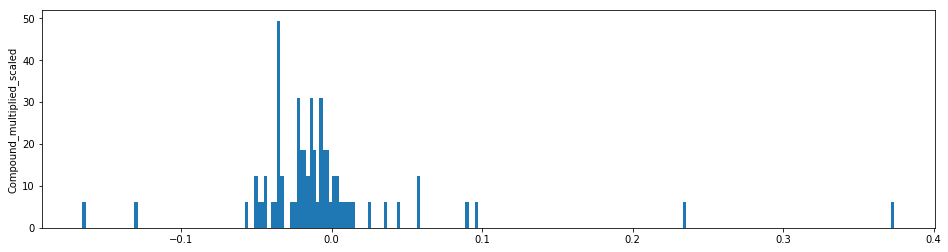

In [0]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] =16.0
fig_size[1] = 4.0

x = df_full['Compound_multiplied_scaled']
plt.hist(x, normed=True, bins=250)
plt.ylabel('Compound_multiplied_scaled');

In [0]:
writer_df = pd.ExcelWriter('df_full.xlsx', engine='xlsxwriter')
df_full.to_excel(writer_df)
writer_df.save()

os.rename('df_full.xlsx', '$AAL.xlsx')